In [31]:
!pip install keras


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:
# Import necessary modules
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
import numpy as np
from keras.models import Model
from keras.layers import Dense, Conv2D, MaxPooling2D, Input, concatenate, Flatten, Dropout, GlobalAveragePooling2D
from keras.optimizers import Adam
import keras.backend as K
from keras.applications import InceptionV3

In [33]:
# Define the paths for the input images and the output dataset
drowning_path = "/content/Drowning"
not_drowning_path = "/content/Swimming"
output_path = "/content/Output"

In [34]:
# Define the image size to use for all images
IMG_SIZE = 224

# Define the label names and corresponding integer values
LABELS = {"drowning": 0, "not_drowning": 1}

In [35]:
drowning_images = []
for filename in os.listdir(drowning_path):
    img = cv2.imread(os.path.join(drowning_path, filename))
    if img is not None and img.size != 0:
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        drowning_images.append([img, LABELS["drowning"]])

not_drowning_images = []
for filename in os.listdir(not_drowning_path):
    img = cv2.imread(os.path.join(not_drowning_path, filename))
    if img is not None and img.size != 0:
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        not_drowning_images.append([img, LABELS["not_drowning"]])

In [36]:
# Combine the two lists of images and shuffle them
images = drowning_images + not_drowning_images
np.random.shuffle(images)

In [37]:
# Split the dataset into training and testing sets
split = int(0.8 * len(images))
train_images = np.zeros((split, 224, 224, 3), dtype=np.float32)
train_labels = np.zeros((split,), dtype=np.float32)
test_images = np.zeros((len(images) - split, 224, 224, 3), dtype=np.float32)
test_labels = np.zeros((len(images) - split,), dtype=np.float32)

for i, (image, label) in enumerate(images):
    if i < split:
        train_images[i] = image
        train_labels[i] = label
    else:
        test_images[i - split] = image
        test_labels[i - split] = label

# Save the training data to a single file
train_data = np.zeros((len(train_images),), dtype=[('image', 'O'), ('label', 'i4')])
for i in range(len(train_images)):
    train_data['image'][i] = train_images[i]
    train_data['label'][i] = train_labels[i]
np.save(os.path.join(output_path, 'train_data.npy'), train_data)


# Save the testing data to a single file
test_data = np.zeros((len(test_images),), dtype=[('image', 'O'), ('label', 'i4')])
for i in range(len(test_images)):
    test_data['image'][i] = test_images[i]
    test_data['label'][i] = test_labels[i]
np.save(os.path.join(output_path, 'test_data.npy'), test_data)

In [38]:
# Normalize the pixel values of the images
train_images = train_images / 255.0
test_images = test_images / 255.0

In [39]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape) 
print(test_labels.shape) 

(141, 224, 224, 3)
(141,)
(36, 224, 224, 3)
(36,)


In [40]:
# Set up input shape
input_shape = (IMG_SIZE, IMG_SIZE, 3)

In [41]:
# Set up GoogLeNet model as base model
googlenet_model = InceptionV3(input_shape=input_shape, include_top=False)

In [42]:
# Freeze all layers in the base model
for layer in googlenet_model.layers:
    layer.trainable = False

In [43]:
# Add custom layers on top of the base model
x = googlenet_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

In [44]:
# Set up the complete model
model = Model(inputs=googlenet_model.input, outputs=output)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 111, 111, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                           

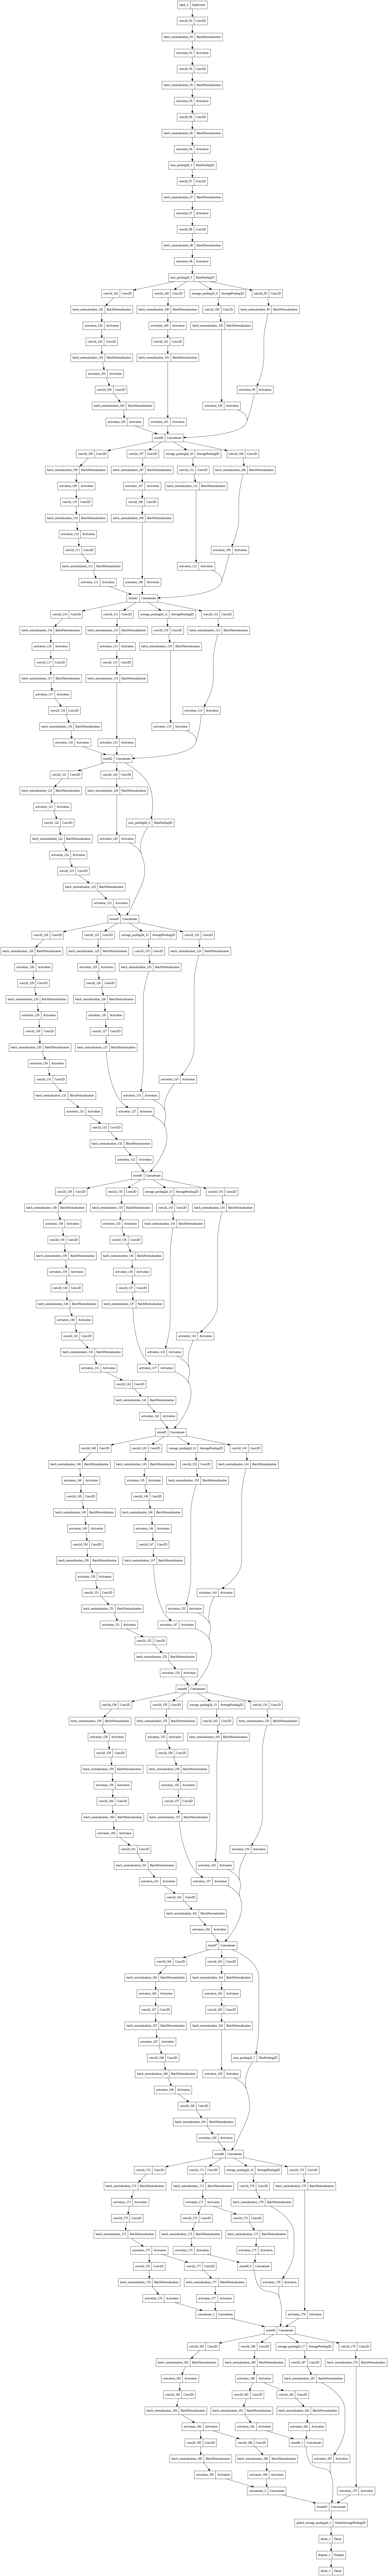

In [45]:
tf.keras.utils.plot_model(model)

In [46]:
# Compile the model
opt = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [47]:
history = model.fit(train_images, train_labels, epochs=30, batch_size=32, validation_split=0.2)

Epoch 1/30
4/4 [==============================] - 37s 5s/step - loss: 1.3318 - accuracy: 0.4643 - val_loss: 0.6274 - val_accuracy: 0.5862
Epoch 2/30
4/4 [==============================] - 17s 4s/step - loss: 0.4320 - accuracy: 0.8125 - val_loss: 0.6271 - val_accuracy: 0.5862
Epoch 3/30
4/4 [==============================] - 17s 4s/step - loss: 0.3482 - accuracy: 0.8482 - val_loss: 0.5681 - val_accuracy: 0.6897
Epoch 4/30
4/4 [==============================] - 18s 5s/step - loss: 0.2528 - accuracy: 0.9286 - val_loss: 0.5346 - val_accuracy: 0.7931
Epoch 5/30
4/4 [==============================] - 16s 4s/step - loss: 0.2266 - accuracy: 0.9196 - val_loss: 0.4824 - val_accuracy: 0.7241
Epoch 6/30
4/4 [==============================] - 19s 5s/step - loss: 0.1403 - accuracy: 0.9286 - val_loss: 0.5022 - val_accuracy: 0.7931
Epoch 7/30
4/4 [==============================] - 30s 8s/step - loss: 0.0947 - accuracy: 0.9821 - val_loss: 0.4523 - val_accuracy: 0.7586
Epoch 8/30
4/4 [==================

In [48]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)

2/2 [==============================] - 4s 459ms/step - loss: 0.6427 - accuracy: 0.6389
Test accuracy: 0.6388888955116272


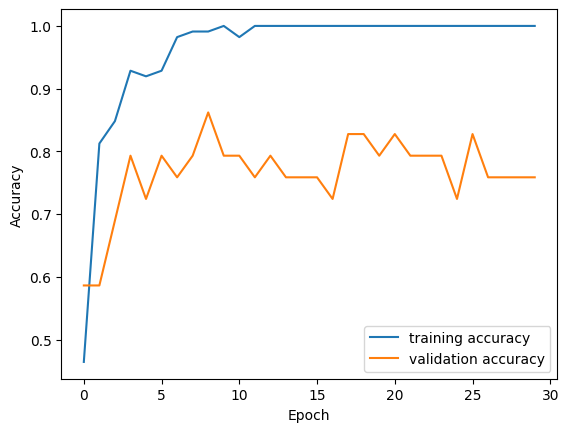

In [49]:
import matplotlib.pyplot as plt

# Plot the accuracy over epochs
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

2/2 [==============================] - 7s 431ms/step
              precision    recall  f1-score   support

         0.0       0.73      0.55      0.63        20
         1.0       0.57      0.75      0.65        16

    accuracy                           0.64        36
   macro avg       0.65      0.65      0.64        36
weighted avg       0.66      0.64      0.64        36

[[11  9]
 [ 4 12]]


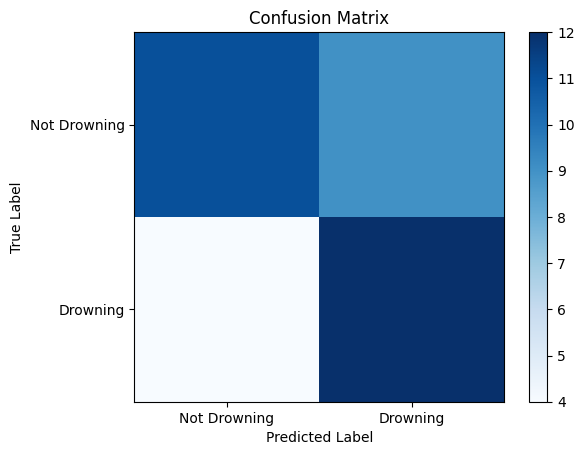

In [50]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Generate predictions for the test data
y_pred = model.predict(test_images)
y_pred = (y_pred > 0.5).astype(int)

# Calculate precision, recall, and F1 score
print(classification_report(test_labels, y_pred))

# Calculate confusion matrix
conf_mat = confusion_matrix(test_labels, y_pred)
print(conf_mat)

# Plot confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(conf_mat, cmap='Blues')

# Add labels and title
ax.set_xticks([0,1])
ax.set_yticks([0,1])
ax.set_xticklabels(['Not Drowning', 'Drowning'])
ax.set_yticklabels(['Not Drowning', 'Drowning'])
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix')

cbar = ax.figure.colorbar(im, ax=ax)

# Display the plot
plt.show()


1/1 [==============================] - 1s 1s/step
Image 1: Not drowning - score: [98.84384]%


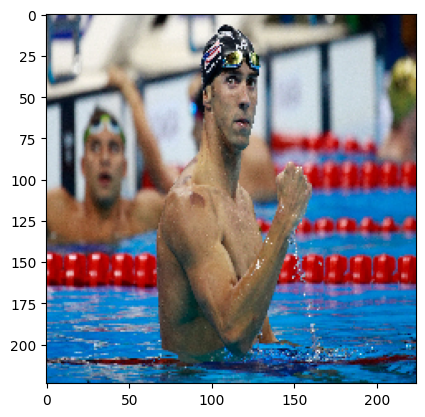

Image 2: Not drowning - score: [99.99902]%


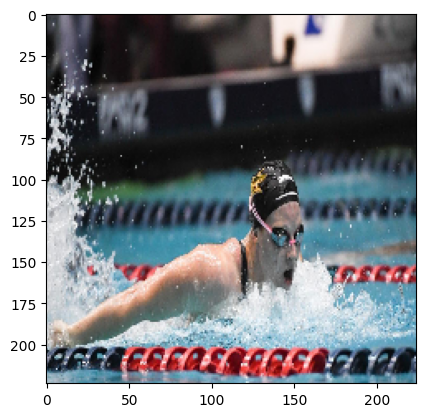

Image 3: Drowning - score: [99.9825]%


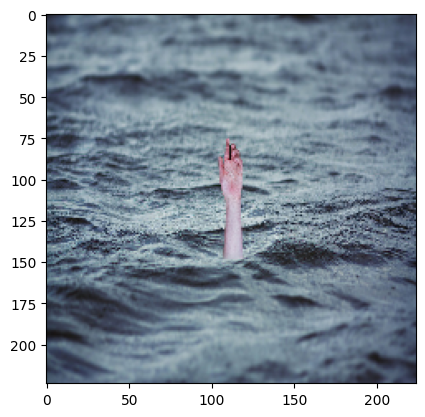

Image 4: Not drowning - score: [78.07447]%


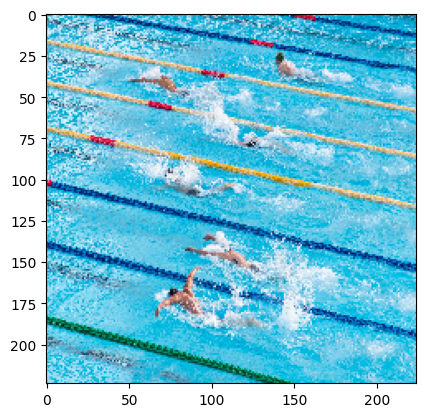

Image 5: Drowning - score: [41.650806]%


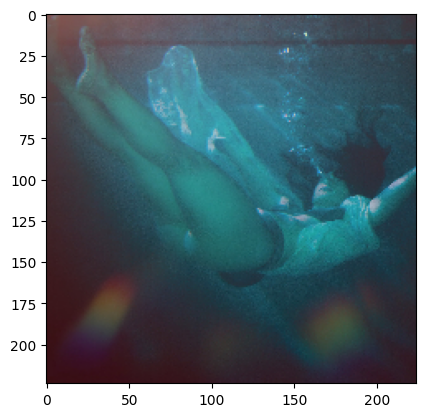

Image 6: Not drowning - score: [93.26264]%


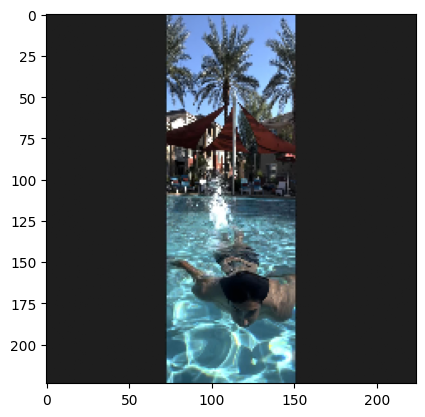

In [55]:
import matplotlib.pyplot as plt

image_paths = ["/content/Prediction/2.jpeg","/content/Prediction/3.jpeg","/content/Prediction/4.jpg","/content/Prediction/5.jpg","/content/Prediction/6.jpg", "/content/Prediction/7.jpg"]
images = []
for path in image_paths:
    image = tf.keras.preprocessing.image.load_img(path, target_size=(224, 224))
    image_array = tf.keras.preprocessing.image.img_to_array(image) / 255.0
    images.append(image_array)

images_array = np.stack(images, axis=0)

predictions = model.predict(images_array)

for i, prediction in enumerate(predictions):
    predicted_class = int(prediction < 0.6)
    if predicted_class == 0:
        print(f"Image {i+1}: Not drowning - score: {prediction*100}%")
    else:
        print(f"Image {i+1}: Drowning - score: {100-prediction*100}%")
    plt.imshow(images[i])
    plt.show()
